In [1]:
#  Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

In [39]:
data['data']['generator']['limit'].shape

(7, 24, 8)

In [40]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [41]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [42]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [43]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [44]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

In [45]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [46]:
data['data']['generator']['limit'].shape

(7, 24, 8)

In [47]:
genLimit.shape

(7, 24, 8)

In [48]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [11]:
#** Define the fixed sets structure to use in the parameters of the gams optimization process
#set genLimitInfo 'Indicate the number of columns of information from generators'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set loadLimitInfo 'Indicate the number of columns of information from loads'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)


In [12]:
# * Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(1, period+1)
_gen = np.arange(1, gen+1)
_Load = np.arange(1, Load+1)

In [13]:
# Aux function to convert numpy into dictionaries

def _auxDictionary(a):
    temp_dictionary = {}
    
    if len(a.shape) == 3:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                for dim2 in np.arange(a.shape[2]):
                    temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
    elif len(a.shape) == 2:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
                
    else:
        for dim0 in np.arange(a.shape[0]):
            temp_dictionary[(dim0+1)] = a[dim0]
                
    return temp_dictionary

#temp_dict1 = _auxDictionary(loadLimit)

In [14]:
# Pyomo imports

import pyomo
import pyomo.opt
import pyomo.environ as pe

In [15]:
# Model creation

model = pe.ConcreteModel()

model.genLimitInfo = pe.Set(initialize=genLimitInfo, 
                            doc='Indicate the number of columns of information from generators')
model.loadLimitInfo = pe.Set(initialize=loadLimitInfo, 
                             doc='Indicate the number of columns of information from loads')

# Sets
model.t = pe.Set(initialize=_t, doc='period')
model.gen = pe.Set(initialize=_gen, doc='generators')
model.loads = pe.Set(initialize=_Load, doc='loads')

In [16]:
# Define the parameters with the data from the excel, such as limits, price, and voltage

model.loadLimit = pe.Param(model.loads, model.t, model.loadLimitInfo, 
                           initialize=_auxDictionary(loadLimit))

model.genLimit = pe.Param(model.gen, model.t, model.genLimitInfo,
                          initialize=_auxDictionary(genLimit))

model.genInfo = pe.Param(model.gen, model.genLimitInfo,
                         initialize=_auxDictionary(genInfo))

model.pMaxImp = pe.Param(model.t,
                         initialize=_auxDictionary(pMaxImp))

model.buyPrice = pe.Param(model.t,
                          initialize=_auxDictionary(buyPrice))

model.pMaxExp = pe.Param(model.t,
                         initialize=_auxDictionary(pMaxExp))

model.sellPrice = pe.Param(model.t,
                           initialize=_auxDictionary(sellPrice))

model.loadActPower = pe.Param(model.loads, model.t,
                              initialize=_auxDictionary(loadLimit[:, :, 0]))
model.optCost = pe.Var()#initialize=0)

In [17]:
# Define the variables for the gams optimization process
# variables fun, derCost, selfConso;

#model.fun = pe.Var(domain=pe.Reals, initialize=0)
model.derCost = pe.Var(domain=pe.Reals, initialize=0)
#model.selfConso = pe.Var(domain=pe.Reals, initialize=0)

In [18]:
#positive variables

model.genActPower = pe.Var(model.gen, model.t, domain=pe.PositiveReals, initialize=1)
model.genExcActPower = pe.Var(model.gen, model.t, domain=pe.PositiveReals, initialize=1)
model.pImp = pe.Var(model.t, domain=pe.PositiveReals, initialize=1)
model.pExp = pe.Var(model.t, domain=pe.PositiveReals, initialize=1)

In [19]:
# Load params
model.loadRedActPower = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)
model.loadCutActPower = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)
model.loadENS = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)

In [20]:
# binary variables

model.genXo = pe.Var(model.gen, model.t, domain=pe.Binary, initialize=0)
model.loadXo = pe.Var(model.loads, model.t, domain=pe.Binary, initialize=0)

In [21]:
# Default behaviour

default_behaviour = pe.Constraint.Skip

In [22]:
# Network constraints

def _maxImpEq(m, t):
    return m.pImp[t] <= m.pMaxImp[t] 

model.MaxImpEq = pe.Constraint(model.t, rule=_maxImpEq)

def _maxExpEq(m, t):
    return m.pExp[t] <= m.pMaxExp[t]

model.MaxExpEq = pe.Constraint(model.t, rule=_maxExpEq)

In [23]:
# Generator constraints with the active generation power

# Maximum generation in generators with normal contract
def _genActMaxEq1(m, g, t):
    if m.genInfo[g, 5] == 1:
        return (m.genActPower[g, t] <= m.genLimit[g, t, 1])
    return default_behaviour
    
model.genActMaxEq1 = pe.Constraint(model.gen, model.t, rule=_genActMaxEq1)

#*Minimum generation in generators with normal contract
def _genActMinEq(m, g, t):
    if m.genInfo[g, 5] == 1:
        return (m.genActPower[g, t] >= m.genInfo[g, 7] * m.genXo[g, t])
    return default_behaviour
    
model.genActMinEq = pe.Constraint(model.gen, model.t, rule=_genActMinEq)

#*Generation in generators with Feed-in tariffs
def _genActMaxEq2(m, g, t):
    if m.genInfo[g, 5] == 2:
        return (m.genActPower[g ,t] + m.genExcActPower[g, t] == m.genLimit[g, t, 1])
    return default_behaviour
    
model.genActMaxEq2 = pe.Constraint(model.gen, model.t, rule=_genActMaxEq2)

In [24]:
# Load constraints

def _loadReactEq(m, l, t):
    return m.loadRedActPower[l, t] <= m.loadLimit[l, t, 3]

model.loadReactEq = pe.Constraint(model.loads, model.t, rule=_loadReactEq)


def _loadCutActPowerEq(m, l, t):
    return m.loadCutActPower[l, t] == m.loadLimit[l, t, 4] * m.loadXo[l, t]

model.loadCutActPowerEq = pe.Constraint(model.loads, model.t, rule=_loadCutActPowerEq)


def _loadENSEq(m, l, t):
    return m.loadENS[l, t] + m.loadRedActPower[l, t] + m.loadCutActPower[l, t] <= m.loadActPower[l, t]

model.loadENSEq = pe.Constraint(model.loads, model.t, rule=_loadENSEq)

In [25]:
# Energy Balance

def _actBalanceEqSimple(m, t):
    temp_sum1 = sum([m.genActPower[i, t] - m.genExcActPower[i, t] for i in np.arange(1, m.gen.last()+1)])
    temp_sum2 = sum(m.loadActPower[:, t])
    
    return temp_sum1 + m.pImp[t] - m.pExp[t] - temp_sum2 == 0

#model.actBalanceSimple = pe.Constraint(model.t, rule=_actBalanceEqSimple)


def _actBalanceEq(m, t):
    temp_gens = sum([m.genActPower[g, t] - m.genExcActPower[g, t] for g in np.arange(1, m.gen.last()+1)])
    
    temp_loads = sum([m.loadActPower[l, t] - m.loadRedActPower[l, t] - m.loadCutActPower[l, t] - m.loadENS[l, t]
                      for l in np.arange(1, m.loads.last() + 1)])
    
    return temp_gens - temp_loads == 0
model.actBalanceSimple = pe.Constraint(model.t, rule=_actBalanceEq)

In [26]:
def _objFun(m):
    temp_gens = sum([m.genActPower[g, t] * m.genLimit[g, t, 3] + m.genExcActPower[g, t] * m.genLimit[g, t, 5]
                     for t in np.arange(1, m.t.last() + 1) for g in np.arange(1, m.gen.last()+1)])
    
    temp_loads = sum([m.loadRedActPower[l, t] * m.loadLimit[l, t, 7] + m.loadCutActPower[l, t] * m.loadLimit[l, t, 8] + m.loadENS[l, t] * m.loadLimit[l, t, 10] 
                      for t in np.arange(1, m.t.last() + 1) for l in np.arange(1, m.loads.last() + 1)])
    
    m.derCost = temp_gens + temp_loads
    
    return temp_gens + temp_loads

model.ObjFun = pe.Objective(rule=_objFun, sense=pe.minimize)

In [27]:
# Create model instance and solve

import cplex
from pyomo.opt import SolverFactory

model.write('res_V4_EC.lp',  io_options={'symbolic_solver_labels': True})

# Create a solver
#opt = pe.SolverFactory('cplex', executable='C:/Program Files/IBM/ILOG/CPLEX_Studio_Community221/cplex/bin/x64_win64/cplex.exe')
opt = pe.SolverFactory('ipopt', executable='C:/Program Files/Ipopt-3.11.1-win64-intel13.1/bin/ipopt.exe')
#opt.options['LogFile'] = 'res_V4_EC.log'
opt.options['print_level'] = 12
opt.options['output_file'] = "res_V5_EC.log"

results = opt.solve(model)#, tee=True)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 768
  Number of variables: 960
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 13.647494316101074
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [28]:
# Extract Pyomo values
# https://stackoverflow.com/questions/67491499/how-to-extract-indexed-variable-information-in-pyomo-model-and-build-pandas-data

def ext_pyomo_vals(vals):
    # make a pd.Series from each 
    s = pd.Series(vals.extract_values(),
                  index=vals.extract_values().keys())
    
    # if the series is multi-indexed we need to unstack it...
    if type(s.index[0]) == tuple:    # it is multi-indexed
        s = s.unstack(level=1)
    else:
        # force transition from Series -> df
        s = pd.DataFrame(s)
        
    return s

In [29]:
# Result extraction

# Generation
result_genActPower = ext_pyomo_vals(model.genActPower)
result_genExcActPower = ext_pyomo_vals(model.genExcActPower)

# Imports/Exports
result_pimp = ext_pyomo_vals(model.pImp)
result_pexp = ext_pyomo_vals(model.pExp)

# Loads
result_loadRedActPower = ext_pyomo_vals(model.loadRedActPower)
result_loadCutActPower = ext_pyomo_vals(model.loadCutActPower)
result_loadENS = ext_pyomo_vals(model.loadENS)

# Booleans
result_genXo = ext_pyomo_vals(model.genXo)
result_loadXo = ext_pyomo_vals(model.loadXo)

In [30]:
# Turn to pandas and save results

# Gens
pd_genActPower = pd.DataFrame(result_genActPower)
pd_genActPower.to_csv('results/cplex_pyomo/genActPower.csv', index=None)

pd_genExcActPower = pd.DataFrame(result_genExcActPower)
pd_genExcActPower.to_csv('results/cplex_pyomo/genExcActPower.csv', index=None)

# Import/Export
pd_pimp = pd.DataFrame(result_pimp)
pd_pimp.to_csv('results/cplex_pyomo/pimp.csv', index=None)

pd_pexp = pd.DataFrame(result_pexp)
pd_pexp.to_csv('results/cplex_pyomo/pexp.csv', index=None)

# Loads
pd_loadRedActPower = pd.DataFrame(result_loadRedActPower)
pd_loadRedActPower.to_csv('results/cplex_pyomo/loadRedActPower.csv', index=None)

pd_loadCutActPower = pd.DataFrame(result_loadCutActPower)
pd_loadCutActPower.to_csv('results/cplex_pyomo/loadCutActPower.csv', index=None)

pd_loadENS = pd.DataFrame(result_loadENS)
pd_loadENS.to_csv('results/cplex_pyomo/loadENS.csv', index=None)


# Booleans
pd_genXo = pd.DataFrame(result_genXo)
pd_genXo.to_csv('results/cplex_pyomo/genXo.csv', index=None)

pd_loadXo = pd.DataFrame(result_loadXo)
pd_loadXo.to_csv('results/cplex_pyomo/loadXo.csv', index=None)

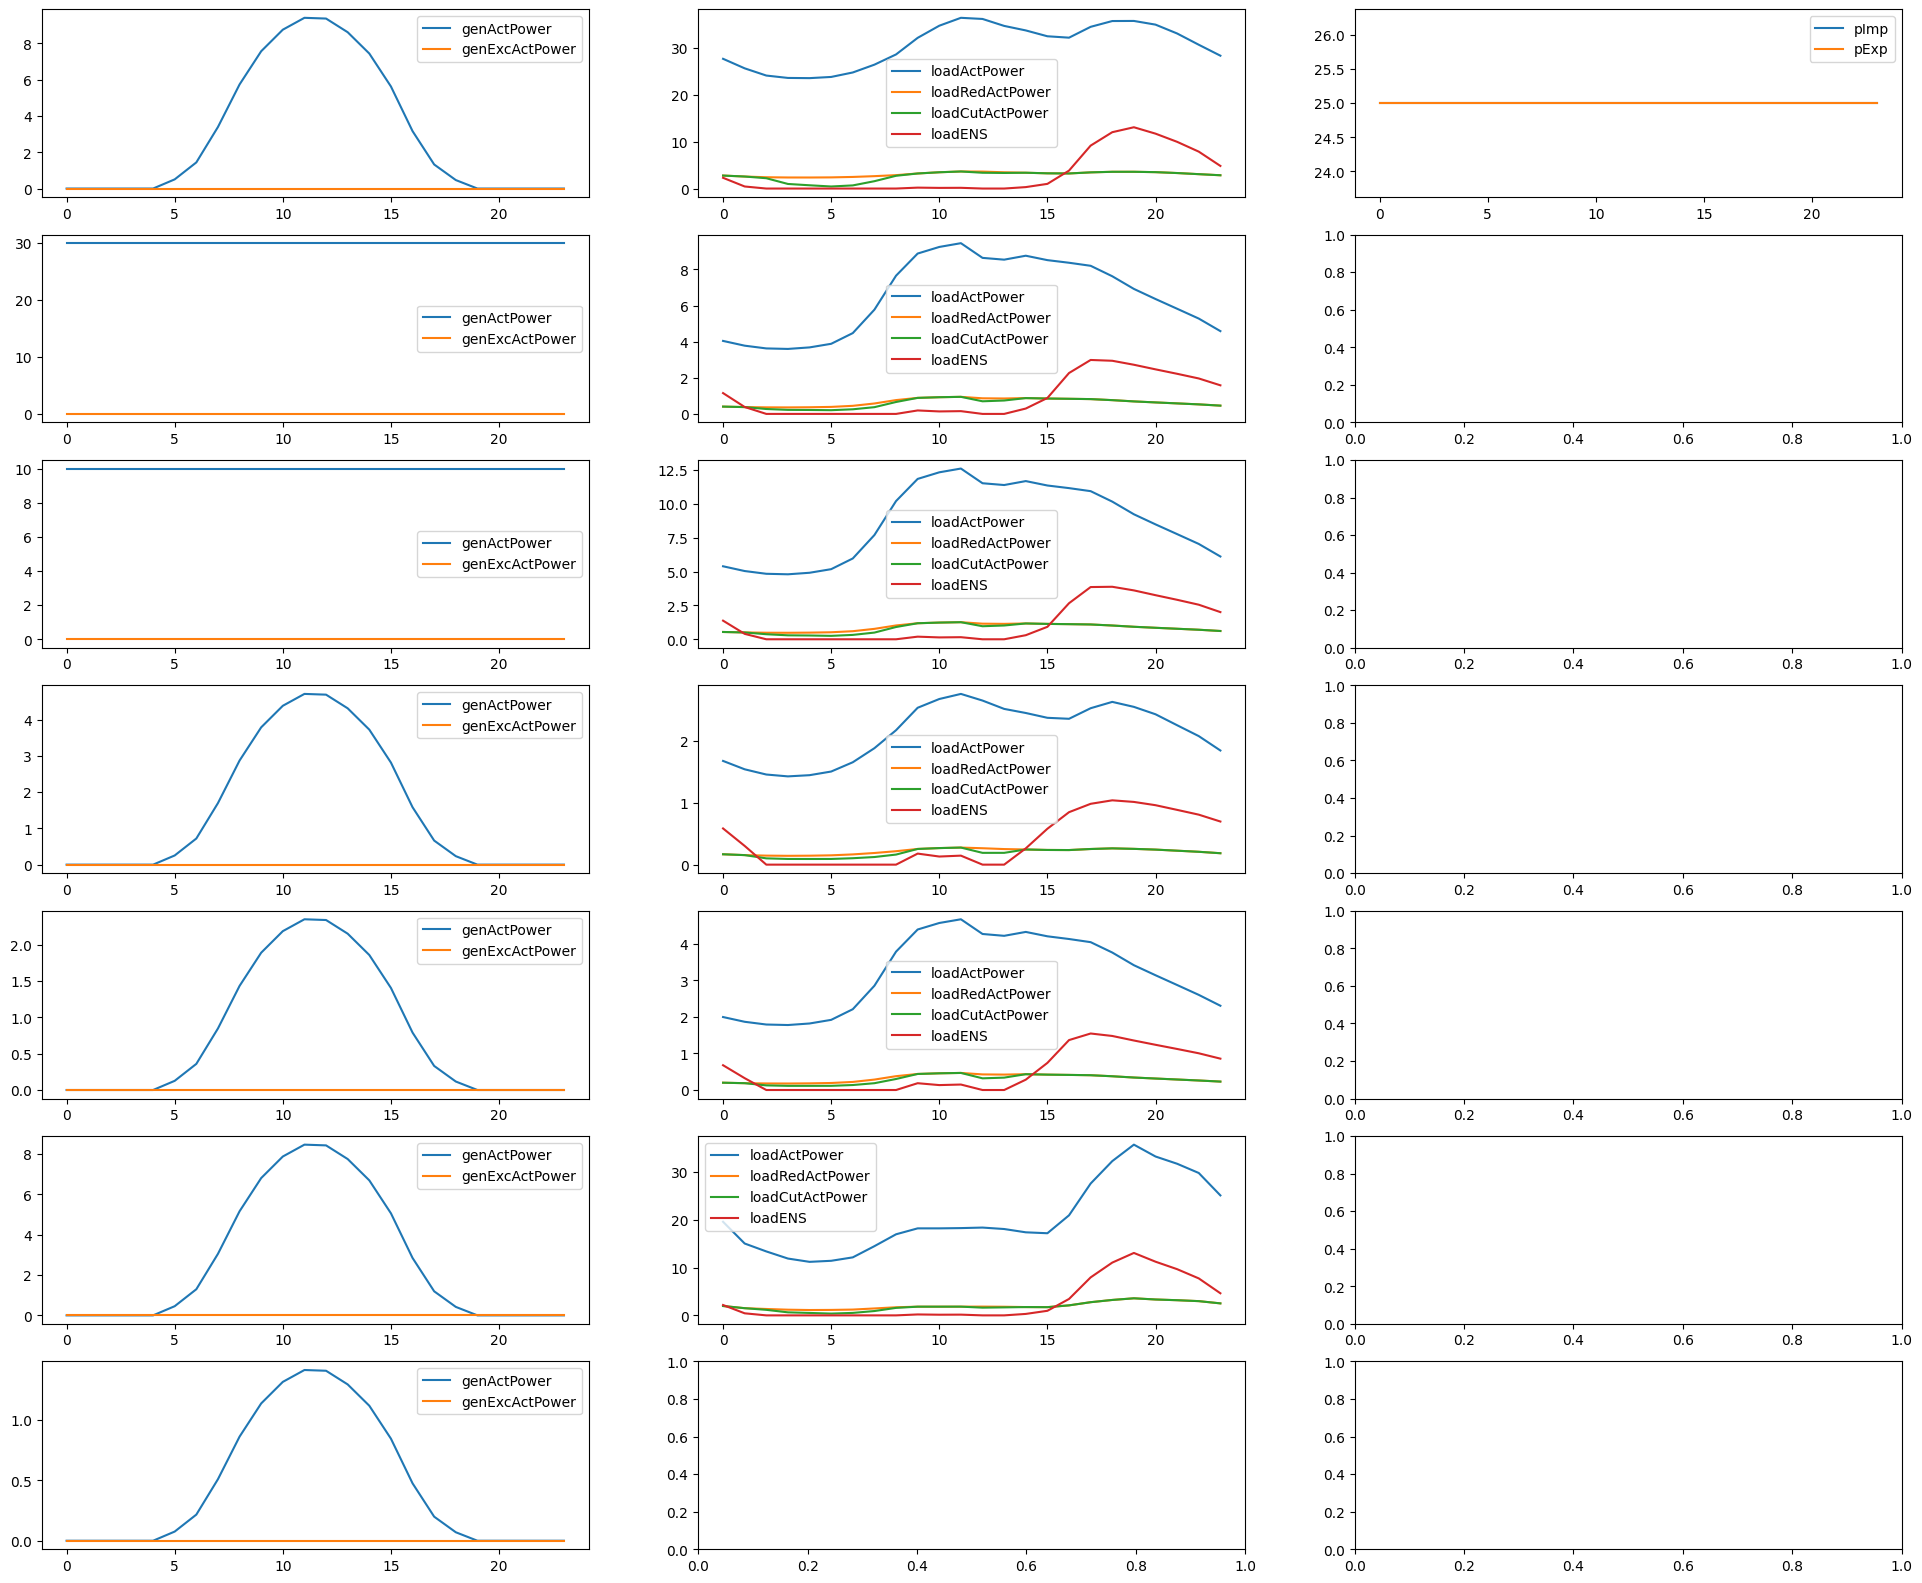

In [31]:
# Plot results

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(24, 20))

for i in np.arange(7):
    # Generators
    axs[i, 0].plot(result_genActPower.values[i])
    axs[i, 0].plot(result_genExcActPower.values[i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(6):
    # Loads
    axs[i, 1].plot(loadLimit[:, :, 0][i, :])
    axs[i, 1].plot(result_loadRedActPower.values[i])
    axs[i, 1].plot(result_loadCutActPower.values[i])
    axs[i, 1].plot(result_loadENS.values[i])
    axs[i, 1].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


axs[0, 2].plot(result_pimp.values)
axs[0, 2].plot(result_pexp.values)
axs[0, 2].legend(['pImp', 'pExp'])


plt.show()

In [33]:
# Total import costs

print('Total import cost: {}'.format(sum(result_pimp.values.ravel() * buyPrice)))

Total import cost: 51.33250050305851
